# Edge Detection and Confidence Scoring in Images

This notebook demonstrates the process of edge detection and confidence scoring in images, particularly focusing on identifying the presence of animals. The workflow involves several key steps:

1. **Import Libraries**: Essential libraries such as NumPy, PIL, and Matplotlib are imported for image processing and visualization.

2. **Convert Image to Grayscale**: The input image is converted to a grayscale format to simplify the edge detection process.

3. **Sobel Gradients**: The Sobel operator is applied to compute the gradient magnitude, highlighting edges by detecting intensity changes.

4. **Binary Edge Map**: A binary edge map is created by applying a threshold to the gradient magnitude. Pixels with gradient values above the threshold are considered edges.

5. **Edge Fraction Calculation**: The edge fraction is computed as the ratio of edge pixels to the total number of pixels, providing a global measure of edge presence.

6. **Blob Detection**: A sliding window scans the binary edge map for large contiguous blobs of edge pixels, recording the size of the largest blob.

7. **Blob Fraction Calculation**: The blob fraction is calculated as the ratio of the largest blob's size to the window size, measuring significant edge structures.

8. **Confidence Score**: The edge fraction and blob fraction are combined to produce a final confidence score, indicating the likelihood of an animal's presence based on detected edges.

By following these steps, the notebook provides a comprehensive approach to edge detection and confidence scoring, useful for various image analysis applications.

In [4]:
# Import necessary libraries
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Enable inline plotting for notebooks
%matplotlib inline

In [5]:
def rgb2gray(image_array):
    """
    Convert an RGB image (as a NumPy array) to grayscale. (https://saturncloud.io/blog/how-to-convert-an-image-to-grayscale-using-numpy-arrays-a-comprehensive-guide/)
    """
    return np.dot(image_array[..., :3], [0.2989, 0.5870, 0.1140])

### Sobel Gradients 
The Sobel operator is an edge detection method that approximates the gradient of an image's intensity. 


#### Applying two 3x3 kernels (matrix):
 > \(G_x\) one for detecting horizontal gradients 

 > \(G_y\) one for vertical gradients (). 


*These kernels highlight changes in pixel intensity along their respective directions.*

For every pixel in the image, the operator extracts a 3x3 patch and performs element-wise multiplication with the kernels, followed by a summation to compute the gradient values in both the x- and y-directions. 
The result is the change in intensity along both axes, which highlights the edges in the image. 
After obtaining \(G_x\) and \(G_y\), the overall edge strength or gradient magnitude is computed using the Euclidean norm: 

\[\text{grad\_magnitude} = \sqrt{G_x^2 + G_y^2} \] 

This value *represents the edge strength at each pixel*, which helps in **identifying boundaries** or gradients within the image. 
The Sobel kernels are designed with a smoothing effect, reducing the influence of noise. 
This smoothing is achieved by giving **higher weights** to the center of the kernel and lower weights to the edges. 

In [6]:
def sobel_gradients(gray_image):
    """
    Compute the gradient magnitude using a Sobel operator.
    
    The Sobel operator guesses the intensity changes (edges) in the image by using
    two 3x3 convolution kernels (matrices). One kernel (Kx) detects horizontal changes, while the
    other kernel (Ky) detects vertical changes. The gradient magnitude is then the combination
    of these two directional gradients.
    """
    # Define Sobel kernels
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=np.float32)
    Ky = np.array([[-1, -2, -1],
                   [ 0,  0,  0],
                   [ 1,  2,  1]], dtype=np.float32)
    
    H, W = gray_image.shape
    # Pad the image to handle borders
    padded = np.pad(gray_image, ((1, 1), (1, 1)), mode='edge') # pads the number array with zeros
    
    # Create the gradient matrices for both x and y directions
    # Pad them with zeros to match the input image size
    Gx = np.zeros_like(gray_image, dtype=np.float32)
    Gy = np.zeros_like(gray_image, dtype=np.float32)
    
    # Add them up, to get the gradient magnitude
    for i in range(H):
        for j in range(W):
            patch = padded[i:i+3, j:j+3]
            Gx[i, j] = np.sum(Kx * patch)
            Gy[i, j] = np.sum(Ky * patch)
    
    grad_magnitude = np.sqrt(Gx**2 + Gy**2)
    return grad_magnitude

## Computing Edge-Based Confidence Score

The function `compute_edge_confidence` calculates an edge-based confidence score to indicate the likelihood of an animal's presence in an image. This process involves several steps:

1. **Convert Image to Grayscale**: The input image is converted to a grayscale image, which simplifies the edge detection process by reducing the image to a single channel.

2. **Compute Gradient Magnitude**: The Sobel operator is applied to the grayscale image to compute the gradient magnitude. This highlights the edges in the image by detecting intensity changes.

3. **Create Binary Edge Map**: A binary edge map is created by applying a threshold to the gradient magnitude. Pixels with gradient values above the threshold are considered edges and set to 1, while others are set to 0.

4. **Calculate Edge Fraction**: The edge fraction is computed as the ratio of edge pixels to the total number of pixels in the image. This gives a global measure of the amount of edges present.

5. **Detect Large Edge Blobs**: A sliding window is used to scan the binary edge map for large contiguous blobs of edge pixels. The size of the largest blob is recorded.

6. **Calculate Blob Fraction**: The blob fraction is calculated as the ratio of the largest blob's size to the window size. This measures the presence of significant edge structures.

7. **Combine Metrics for Confidence Score**: The edge fraction and blob fraction are combined to produce a final confidence score, which ranges from 0 to 1. A higher score indicates a higher likelihood of an animal's presence based on the detected edges.

In [7]:
def compute_edge_confidence(pil_image, edge_threshold=50, window_size=20):
    """
    Computes an edge-based confidence score indicating the likelihood of an animal presence.
    
    Parameters:
      - pil_image: A PIL Image object.
      - edge_threshold: Threshold on gradient magnitude for edge detection.
      - window_size: Size of the sliding window to capture local edge blobs.
    
    Returns:
      - confidence: A value between 0 and 1.
      - edge_map: The binary edge image (for debugging/visualization).
    """
    # Convert the PIL image to grayscale (as a NumPy array)
    gray_array = np.array(pil_image.convert('L'), dtype=np.float32)
    
    # Compute the gradient magnitude
    grad_mag = sobel_gradients(gray_array)
    
    # Create a binary edge map: pixels above edge_threshold are set to 1
    edge_map = (grad_mag > edge_threshold).astype(np.uint8)
    
    # Global edge fraction: ratio of edge pixels to total pixels
    edge_fraction = np.sum(edge_map) / edge_map.size
    
    # Look for a large blob by scanning with a sliding window
    H, W = edge_map.shape
    max_blob = 0
    for i in range(0, H - window_size + 1, window_size):
        for j in range(0, W - window_size + 1, window_size):
            window = edge_map[i:i+window_size, j:j+window_size]
            blob_sum = np.sum(window)
            if blob_sum > max_blob:
                max_blob = blob_sum
    blob_fraction = max_blob / (window_size * window_size)
    
    # Combine both metrics to get a confidence score
    confidence = (edge_fraction + blob_fraction) / 2.0
    return confidence, edge_map


## Basic Workflow Overview

This notebook outlines a step-by-step process for detecting edges in images and calculating a confidence score to determine the likelihood of an animal's presence. Here's a simplified overview:

1. **Import Libraries**: Load essential libraries for image processing and visualization.
2. **Convert Image to Grayscale**: Simplify the image by converting it to grayscale.
3. **Apply Sobel Operator**: Detect edges by calculating the gradient magnitude.
4. **Create Binary Edge Map**: Identify edges by applying a threshold to the gradient magnitude.
5. **Calculate Edge Fraction**: Measure the proportion of edge pixels in the image.
6. **Detect Large Edge Blobs**: Find significant edge structures using a sliding window.
7. **Calculate Blob Fraction**: Measure the size of the largest edge blob.
8. **Compute Confidence Score**: Combine edge and blob fractions to determine the likelihood of an animal's presence.

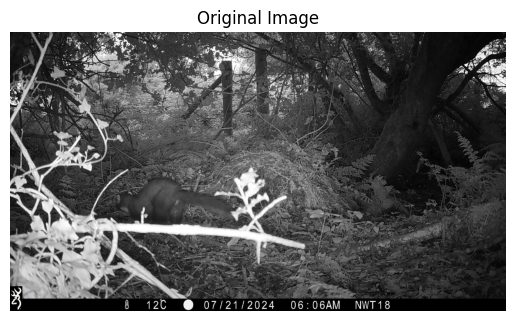

In [8]:
# Load a sample image using PIL
sample_image_path = r"C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\ds_researchATU\IMG_0198.JPG"
img = Image.open(sample_image_path)

# Display the image
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
plt.show()

Edge-based confidence score: 0.7484092881944444


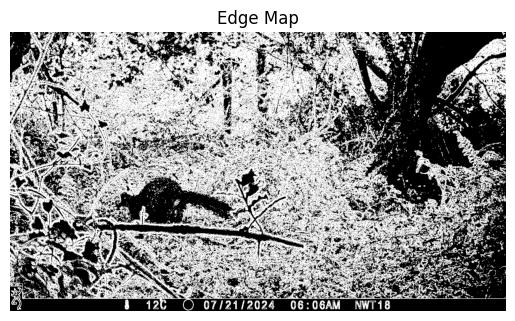

In [9]:
# Compute edge-based confidence and get the edge map
confidence, edge_map = compute_edge_confidence(img, edge_threshold=50, window_size=20)

print("Edge-based confidence score:", confidence)

# Visualize the edge map
plt.imshow(edge_map, cmap="gray")
plt.title("Edge Map")
plt.axis("off")
plt.show()

In [10]:
# Experiment with different edge thresholds and window sizes
for thresh in [30, 50, 70]:
    for w_size in [10, 20, 30]:
        conf, _ = compute_edge_confidence(img, edge_threshold=thresh, window_size=w_size)
        print(f"Edge Threshold: {thresh}, Window Size: {w_size} -> Confidence: {conf:.3f}")

Edge Threshold: 30, Window Size: 10 -> Confidence: 0.825
Edge Threshold: 30, Window Size: 20 -> Confidence: 0.821
Edge Threshold: 30, Window Size: 30 -> Confidence: 0.817
Edge Threshold: 50, Window Size: 10 -> Confidence: 0.762
Edge Threshold: 50, Window Size: 20 -> Confidence: 0.748
Edge Threshold: 50, Window Size: 30 -> Confidence: 0.737
Edge Threshold: 70, Window Size: 10 -> Confidence: 0.714
Edge Threshold: 70, Window Size: 20 -> Confidence: 0.687
Edge Threshold: 70, Window Size: 30 -> Confidence: 0.670


Average : 0.7634

Edge-based confidence score: 0.8831346450617283


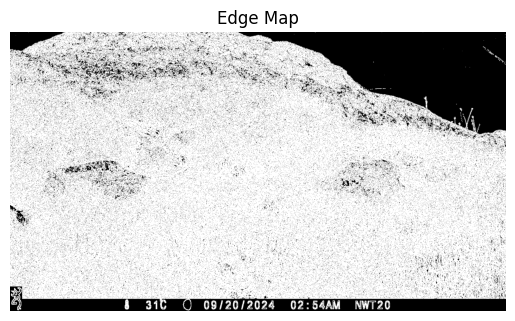

Edge Threshold: 30, Window Size: 10 -> Confidence: 0.825
Edge Threshold: 30, Window Size: 20 -> Confidence: 0.821
Edge Threshold: 30, Window Size: 30 -> Confidence: 0.817
Edge Threshold: 50, Window Size: 10 -> Confidence: 0.762
Edge Threshold: 50, Window Size: 20 -> Confidence: 0.748
Edge Threshold: 50, Window Size: 30 -> Confidence: 0.737
Edge Threshold: 70, Window Size: 10 -> Confidence: 0.714
Edge Threshold: 70, Window Size: 20 -> Confidence: 0.687
Edge Threshold: 70, Window Size: 30 -> Confidence: 0.670


In [11]:
# Load a different sample image using PIL
sample_image_path = r"C:\Users\rf4thyrvm\Documents\CritterSnap\data\example\ds_researchATU\IMG_0001.JPG" 
img1 = Image.open(sample_image_path)

# Display the image
plt.imshow(img1)
plt.title("Original Image")
plt.axis("off")
# Compute edge-based confidence and get the edge map
confidence, edge_map = compute_edge_confidence(img1, edge_threshold=50, window_size=20)

print("Edge-based confidence score:", confidence)

# Visualize the edge map
plt.imshow(edge_map, cmap="gray")
plt.title("Edge Map")
plt.axis("off")
plt.show()

# Experiment with different edge thresholds and window sizes
for thresh in [30, 50, 70]:
    for w_size in [10, 20, 30]:
        conf, _ = compute_edge_confidence(img, edge_threshold=thresh, window_size=w_size)
        print(f"Edge Threshold: {thresh}, Window Size: {w_size} -> Confidence: {conf:.3f}")

Average: 0.7534